# Analyze Voltage Steps (Clampfit ABF Format)

Be sure to cite:
    
"Analysis of electrophysiological recordings was performed with custom software written for this project using Python 3.7 and the pyABF module¹."

[1] Harden, SW (2020). pyABF 2.2.3. [Online]. Available: https://pypi.org/project/pyabf/, Accessed on: March 20, 2020.

### User Input

In [1]:
file_in = '19n13066.abf'     # Assumes python notebook is in the same dir as the ABF file

### Import Packages

In [2]:
import pyabf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

### Read in the data

In [3]:
abf = pyabf.ABF(file_in)   # Read in time series from ABF file

### Default Values

In [4]:
# Get all sweeps in the file
sweep_count = len(abf.sweepList)
display(HTML("<br><font size = 4, color = 'blue'>The file " + file_in + " has " + str(sweep_count) + " sweeps. </h3></font><br><br>"))
scale_ms = abf.dataPointsPerMs
scale_s = scale_ms * 1000

### Built-in pyABF 3D plot

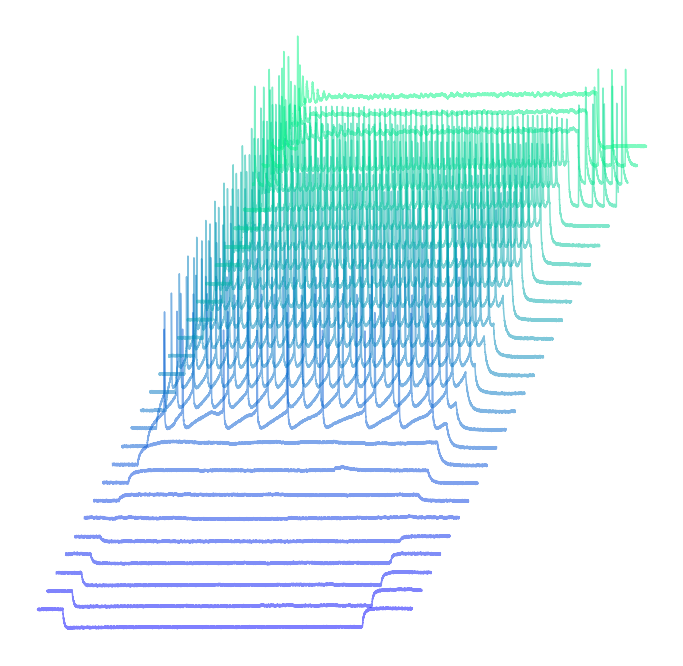

In [5]:
def default_3D (sweep_list, cm): # Define the built-in plotting function
    
    """Creates a 3D map using the built-in pyABF function, 
    but does not allow for much customization. Good for quick visualization"""
    
    colors = [cm(x/abf.sweepCount) for x in sweep_list]
    # colors.reverse()  # Remove the "#" to reverse the color order

    # Set up the figure
    plt.figure(figsize=(12, 12))
    
    # Cycle through all the sweeps in the abf file and plot the data
    for sweepNumber in sweep_list:
        abf.setSweep(sweepNumber)
        i1, i2 = 0, int(abf.dataRate * 1) # set start and stop times for whole trace
        dataX = abf.sweepX[i1:i2] + .025 * sweepNumber # Get X values for the whole trace + x-offset
        dataY = abf.sweepY[i1:i2] + 15 * sweepNumber   # Get Y Values for the whole trace + y-offset
        plt.plot(dataX, dataY, color=colors[sweepNumber], alpha=.5) # Plot the data in "3d"
    
    # Removed axes, ticks, and labels
    plt.gca().axis('off')
    
    # save the figure to disk. Filename will be the abf filename + the tag "_builtin3d.jpg"
    # Default is 300 DPI with portrait orientation 
    plt.savefig (file_in.replace('.abf','_builtin3d.jpg'), dpi=300, orientation='portrait')

    
    
#------------ Run the default_3d () function -----------------------#
# Use a custom colormap to create a different color for every sweep. 
# Link to colormaps at the end of the script
cm = plt.get_cmap("winter")
sweep_list = abf.sweepList 
default_3D(sweep_list, cm)


## Custom 3D plot (Can be modified)

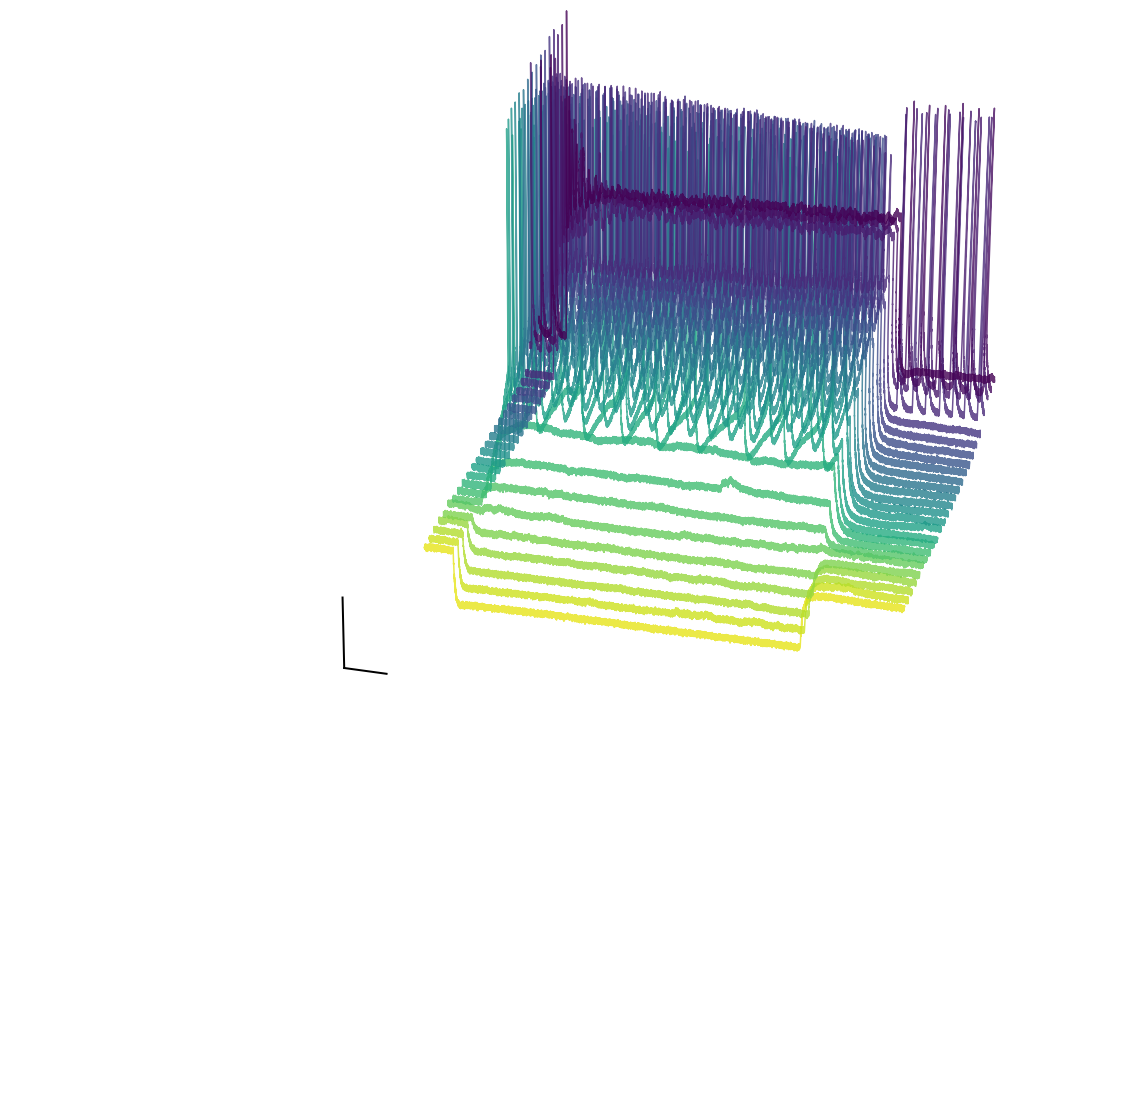

In [6]:
def custom_3d (sweep_list, cm):
    """Use the mpl_toolkits package to construct a customizable 
    3D plot of the full length and range of sweeps"""
    
    # Set default values for min/max of X and Y values
    x_max = 0
    x_min = 0
    y_max = 0
    y_min = 0
    
    i = 0  # Counter for indexing z-offset, increases + 1 with each sweep
    
    # Set up the figure using one subplot with 3 axes 
    fig = plt.figure(figsize =(20,20))
    ax = fig.add_subplot(111, projection='3d')

    for sweep in sweep_list:
        colors = [cm(x/abf.sweepCount) for x in sweep_list]
        colors.reverse()
        
        # Get X and Y from In0
        abf.setSweep (sweepNumber = sweep, channel = 0)
        x = abf.sweepX
        y = abf.sweepY
        
        # Get max and min of x, y, and cmd
        x_max = max (x)
        x_min = min (x)
        y_max = max ([max(y), y_max])
        y_min = min ([min(y), y_min])
    
        ax.plot (x, y, i*4, zdir = 'y', alpha = 0.8, color = colors[i])        
        i = i + 1
    
    # Hide gridlines
    ax.grid (False)

    # Hide ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Hide Axes
    ax.axis('off')

    # Set axis limits
    x_min = -0.2
    y_min = y_min + y_min * 0.15
    y_max = y_max + y_max * 0.15
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Calculate lengths of scale bars
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_scale_factor = 1/12.9 # adjusts length of x scale bar
    y_scale_factor = 1/6.5  # adjusts length of y scale bar
    
    # Calculate Positions of scale bars
    x_padding = 0.005        # adjusts position of x scale bar relative to x_min
    y_padding = 0.1         # adjusts position of y scale bar relative to y_min
    x_width = [x_min - abs(x_min) * x_padding, (x_min - abs(x_min) * x_padding) + (x_range * x_scale_factor)]
    y_height = [y_min - abs(y_min) * y_padding, (y_min - abs(y_min) * y_padding) + ( y_range * y_scale_factor)]

    # Add scale bars to plot
    ax.plot (x_width, [y_min - abs(y_min) * y_padding] * 2, 2, zdir = 'y', lw = 2, color = 'black')
    ax.plot ([x_min - (abs(x_min) * x_padding)] * 2, y_height, 2, zdir = 'y', lw = 2, color = 'black')
    
    # Rotate the view. Increments of 2-5 work best.
    ax.view_init(azim = -75)
    
    display(HTML("<br><b> Scale Bar: " + str(int(y_range * y_scale_factor)) + ' mV, ' 
                 + str(int(x_range * x_scale_factor * 1000)) + ' ms</b>'))
    
    # save the figure
    plt.savefig (file_in.replace('.abf','_custom3d.jpg'), dpi=300, orientation='portrait')



#------- Run the custom_3d() function -------#
cm = plt.get_cmap("viridis")
custom_3d(sweep_list, cm)

## 3D Plot with a subset of sweeps

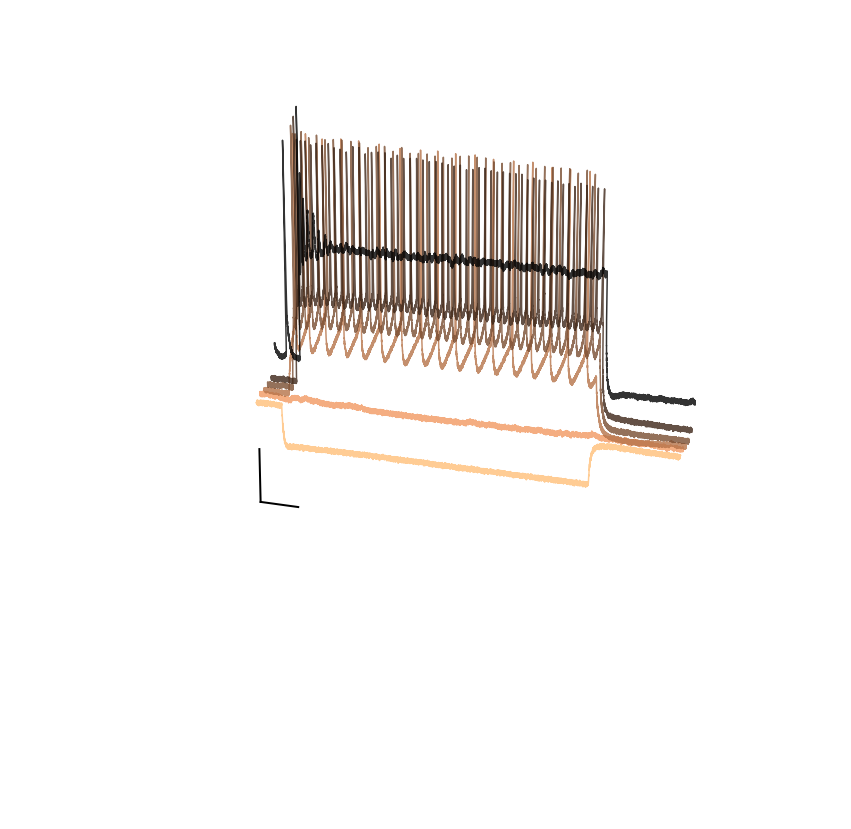

In [10]:
def subset_3d (sweep_list, cm):
    """Same as Custom 3D Plot except that it only plots the sweeps 
    specified in the sweep_list argument. Plots the full length of each sweep."""
    
    # Default min/max for both axes is the origin (0,0)
    x_max = 0
    x_min = 0
    y_max = 0
    y_min = 0
    
    i = 0 # indexer/counter for the # sweeps plotted
    
    # Set up a figure with 1 subplot with 3 axes
    fig = plt.figure(figsize =(15,15))
    ax = fig.add_subplot(111, projection='3d')

    # Iterate through the list of sweeps supplied by the user
    for sweep in sweep_list:
        
        # Determine sweep color by it's position in the list
        #colors = cm
        colors = [cm(x/abf.sweepCount) for x in sweep_list]
        colors.reverse() # to keep colors in forward order, place a # in front of this line
        
        # Get X and Y from In0
        abf.setSweep (sweepNumber = sweep, channel = 0)
        x = abf.sweepX
        y = abf.sweepY
        
        # Get max and min of x, y, and cmd
        x_max = max (x)
        x_min = min (x)
        y_max = max ([max(y), y_max])
        y_min = min ([min(y), y_min])
    
        ax.plot (x, y, i*4, zdir = 'y', alpha = 0.8, color = colors[i])        
        i = i + 1
    
    # Hide gridlines
    ax.grid (False)

    # Hide ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Hide Axes
    ax.axis('off')

    # Set axis limits
    x_min = 0
    y_min = y_min + y_min * 0.15
    y_max = y_max + y_max * 0.15
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Calculate lengths of scale bars
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_scale_factor = 1/10.9 # adjusts length of x scale bar
    y_scale_factor = 1/6.5  # adjusts length of y scale bar
    
    # Calculate Positions of scale bars
    x_padding = 0.05        # adjusts position of x scale bar relative to x_min
    y_padding = 0.1         # adjusts position of y scale bar relative to y_min
    x_width = [x_min - abs(x_min) * x_padding, (x_min - abs(x_min) * x_padding) + (x_range * x_scale_factor)]
    y_height = [y_min - abs(y_min) * y_padding, (y_min - abs(y_min) * y_padding) + ( y_range * y_scale_factor)]

    # Add scale bars to plot
    ax.plot (x_width, [y_min - abs(y_min) * y_padding] * 2, 2, zdir = 'y', lw = 2, color = 'black')
    ax.plot ([x_min - (abs(x_min) * x_padding)] * 2, y_height, 2, zdir = 'y', lw = 2, color = 'black')
    
    # Rotate the view. Increments of 2-5 work best.
    ax.view_init(azim = -75)
    
    display(HTML("<br><b> Scale Bar: " + str(int(y_range * y_scale_factor)) + ' mV, ' 
                 + str(int(x_range * x_scale_factor * 1000)) + ' ms</b>'))
    
    # save the figure
    plt.savefig (file_in.replace('.abf','_subset3d.jpg'), dpi=300, orientation='portrait')

    
    
#------- Run the subset_3d() Function -----#
# cm = ['red', 'green', 'blue', orange] 
cm = plt.get_cmap("copper")
sweep_subset = [0,5,10,15,20,25]
subset_3d(sweep_subset, cm)

## 3D Action Potential Plot (Different Sweeps)

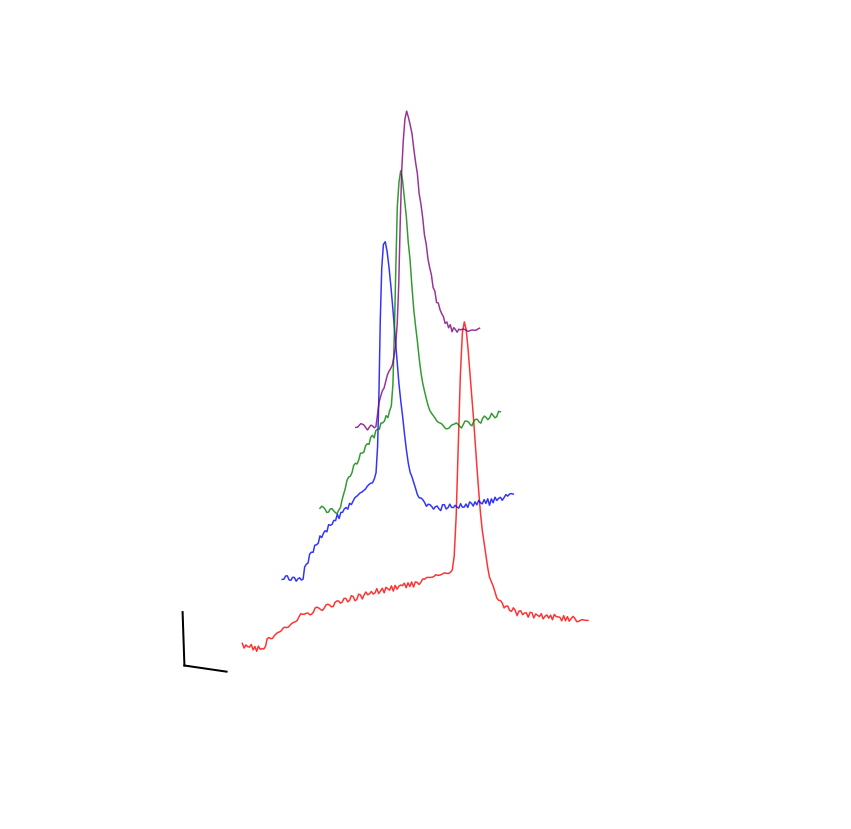

In [11]:
def ap_3d (ap):
    
    """Takes individual sweeps from an ABF file and plots specific timepoints within each sweep"""
    
    # Get starting min/max for both axes as the first datapoint in the specified
    # Region of the first sweep
    x_max = abf.sweepX[int(ap.end[0] * scale_s)]
    x_min = abf.sweepX[int(ap.start[0] * scale_s)]
    y_max = abf.sweepY[int(ap.end[0] * scale_s)]
    y_min = abf.sweepX[int(ap.start[0] * scale_s)]
    i = 0
    
    # Construct the figure panel with 3 dimensions
    fig = plt.figure(figsize =(15,15))
    ax = fig.add_subplot(111, projection='3d')

    # Iterate through the list of sweeps and plots only the specified time windows
    for index, row in ap.iterrows():
        
        # Get color for each sweep based on the order of the sweep in the list
        colors = cm  # For user-specified color map
        #colors = [cm(x/len(ap.sweep)) for x in range(0,len(ap.sweep))] # for python colormaps
        #colors.reverse()  # Reverse the colors if you wish, if not, add a "#" to have python ignore it
        
        # Get start and end times in datapoints
        start = int(row['start'] * scale_s)
        end = int(row['end'] * scale_s)
        
        # Get X and Y from Channel 0
        abf.setSweep (sweepNumber = int(row['sweep']), channel = 0)
        x = abf.sweepX [start:end]
        y = abf.sweepY [start:end]
        
        # Get max and min of x and y for the widest and tallest sweeps so far
        x_max = max ([max(x), x_max])
        x_min = min ([min(x), x_min])
        y_max = max ([max(y), y_max])
        y_min = min ([min(y), y_min])
    
        # Plot the sweep in 3D. "i + 1" is the z-offset for spacing along the z axis 
        ax.plot (x, y, i+1, zdir = 'y', alpha = 0.8, color = colors[i])    
        
        i = i + 1
    
    # Hide gridlines
    ax.grid (False)

    # Hide ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Hide Axes
    ax.axis('off')
    
    # Calculate lengths of scale bars
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_scale_factor = 1/8 # adjusts length of x scale bar
    y_scale_factor = 1/6.5  # adjusts length of y scale bar
    
    # Calculate Positions of scale bars
    x_padding = 0.05        # adjusts position of x scale bar relative to x_min
    y_padding = 0.1         # adjusts position of y scale bar relative to y_min
    x_width = [x_min - abs(x_min) * x_padding, (x_min - abs(x_min) * x_padding) + (x_range * x_scale_factor)]
    y_height = [y_min - abs(y_min) * y_padding, (y_min - abs(y_min) * y_padding) + ( y_range * y_scale_factor)]

    # Add scale bars to plot
    ax.plot (x_width, [y_min - abs(y_min) * y_padding] * 2, 1, zdir = 'y', lw = 2, color = 'black')
    ax.plot ([x_min - (abs(x_min) * x_padding)] * 2, y_height, 1, zdir = 'y', lw = 2, color = 'black')
    
    # Rotate the view. Increments of 2-5 work best.
    ax.view_init(azim = -75)
    
    display(HTML("<br><b> Scale Bar: " + str(int(y_range * y_scale_factor)) + ' mV, ' 
                 + str(int(x_range * x_scale_factor * 1000)) + ' ms</b>'))
    
    # save the figure
    plt.savefig (file_in.replace('.abf','_ap3d.jpg'), dpi=300, orientation='portrait')


#----------------------------------- Run the ap_3d() Function ------------------------------#

# Construct an empty dataframe to hold the associated values
ap = pd.DataFrame({'sweep': [], 'start': [], 'end': []})

# Choose or create the color map
#cm = plt.get_cmap("ocean")
cm = ['red', 'blue', 'green', 'purple'] # custom color map with one color for every sweep I want to plot
ap.sweep = [12, 18, 21, 25]  # Clampfit sweep # -1 because Python starts numbering at 0, not 1
ap.start = [0.066, 0.066, 0.066, 0.066] # Start times in the same order of the sweeps in ap.sweep (in ms)
ap.end = [0.085, 0.0791, 0.0765, 0.0734] # End times in the same order of the sweeps in ap.sweep (in ms)

ap_3d(ap) # pass the ap data frame to the ap_3d Function

## 3D Action Potential Plot (Same Sweep)

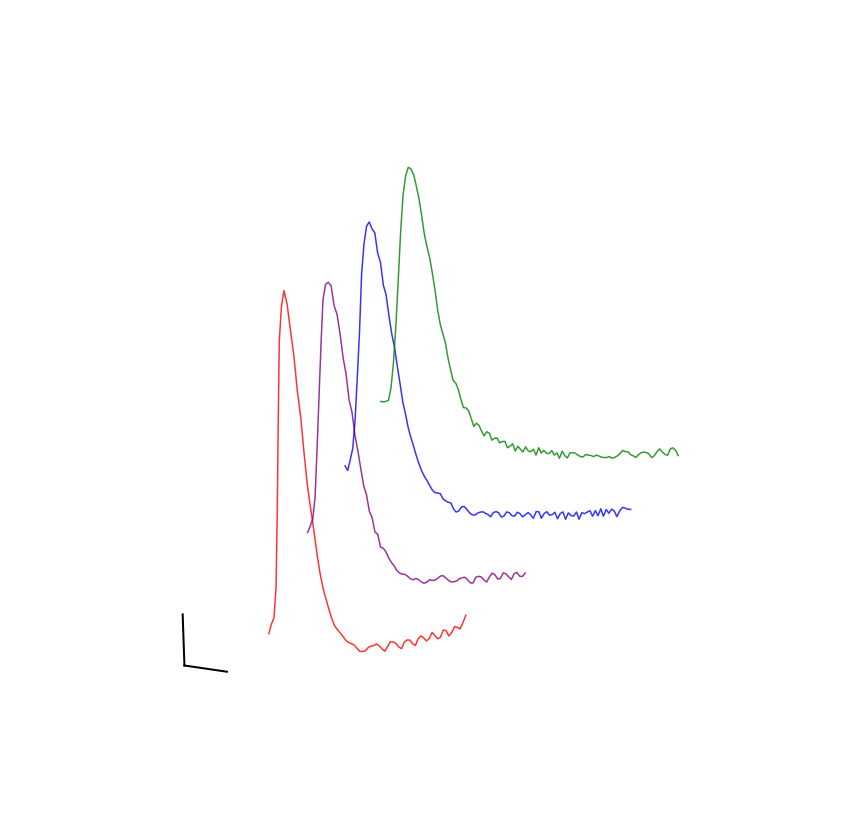

In [12]:
def sweep_3d (sweep, ap):
    
    """Takes one sweep and plots the user-specified events from within that sweep """
    
    # Get starting min/max for both axes starting from the first datapoint in the first sweep
    x_max =abf.sweepX[int(ap.start[0] * scale_s)]
    x_min = abf.sweepX[int(ap.end[0] * scale_s)]
    y_max = abf.sweepY[int(ap.end[0] * scale_s)]
    y_min = abf.sweepY[int(ap.start[0] * scale_s)]
    i = 0
    
    # Construct the figure panel with 3 dimensions
    fig = plt.figure(figsize =(15,15))
    ax = fig.add_subplot(111, projection='3d')

    # Iterate through the list of start and end times within a single sweep
    for index, row in ap.iterrows():
        
        # Get color for each sweep based on the order of the sweep in the list
        colors = cm  # for custom color maps
        #colors = [cm(x/len(ap.start)) for x in range(0,len(ap.start))]  # For python color maps
        #colors.reverse()  # Reverse the colors if you wish, if not, add a "#" to have python ignore it
        
        # Get start and end times in datapoints
        start = int(row['start'] * scale_s)
        end = int(row['end'] * scale_s)
        
        # Get X and Y from Channel 0
        abf.setSweep (sweepNumber = sweep, channel = 0)
        x = abf.sweepX [start:end]
        x = x - min(x)  # sets minimum x value to 0 even if the actual start time is not 0
        y = abf.sweepY [start:end]
        
        # Get max and min of x and y for the widest and tallest sweeps so far
        x_max = max ([max(x)-min(x), x_max])
        x_min = min ([max(x)-min(x), x_min])
        y_max = max ([max(y), y_max])
        y_min = min ([min(y), y_min])
    
        # Plot the sweep in 3D. "i + 1" is the z-offset for spacing along the z axis 
        ax.plot (x, y, i+1, zdir = 'y', alpha = 0.8, color = colors[i])    
        
        i = i + 1
    
    # Hide gridlines
    ax.grid (False)

    # Hide ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Hide Axes
    ax.axis('off')
    
    # Calculate length of scale bars
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_scale_factor = 1/40   # Adjusts length of x scale bar
    y_scale_factor = 1/6.5  # Adjusts length of y scale bar
    
    # Calculate positions of scale bars
    x_padding = 0.05        # Adjusts position of x scale bar
    y_padding = 0.2         # Adjusts position of y scale bar
    x_width = 0 - x_range * x_padding, (0 - x_range * x_padding) + (x_range * x_scale_factor)
    y_height = [y_min - abs(y_min) * y_padding], [y_min - abs(y_min) * y_padding] +( y_range * y_scale_factor)

    # Add 3rd dimension here
    ax.plot (x_width, [y_min - abs(y_min * y_padding)] * 2, 1, zdir = 'y', lw = 2, color = 'black')
    ax.plot ([0-x_range * x_padding] * 2, y_height, 1, zdir = 'y', lw = 2, color = 'black')
    
    # Rotate the view. Increments of 2-5 work best.
    ax.view_init(azim = -75)
    
    display(HTML("<br><b> Scale Bar: " + str(int(y_range * y_scale_factor)) + ' mV, ' 
                 + str(int(x_range * x_scale_factor * 1000)) + ' ms</b>'))
    
    
    # save the figure
    plt.savefig (file_in.replace('.abf','_sweep3d.jpg'), dpi=300, orientation='portrait')


#--------------------------------Run sweep_3d() Function -------------------------------------#
# Create an empty data frame to hold the user-specified data
ap = pd.DataFrame({'start': [], 'end': []})

#cm = plt.get_cmap("ocean")   # Specify the python colormap
cm = ["red", "purple", "blue", "green"]
sweep = 21     # Clampfit sweep # -1 because Python starts numbering at 0, not 1
ap.start = [0.070, 0.0769, 0.0862, 0.0975]  # Enter start times of individual events within the sweep (in ms)
ap.end = [0.0772, 0.085, 0.097, 0.109]      # Enter the stop times of individual events within the sweep (in ms)

sweep_3d(sweep, ap)

## Standard 2D Plot

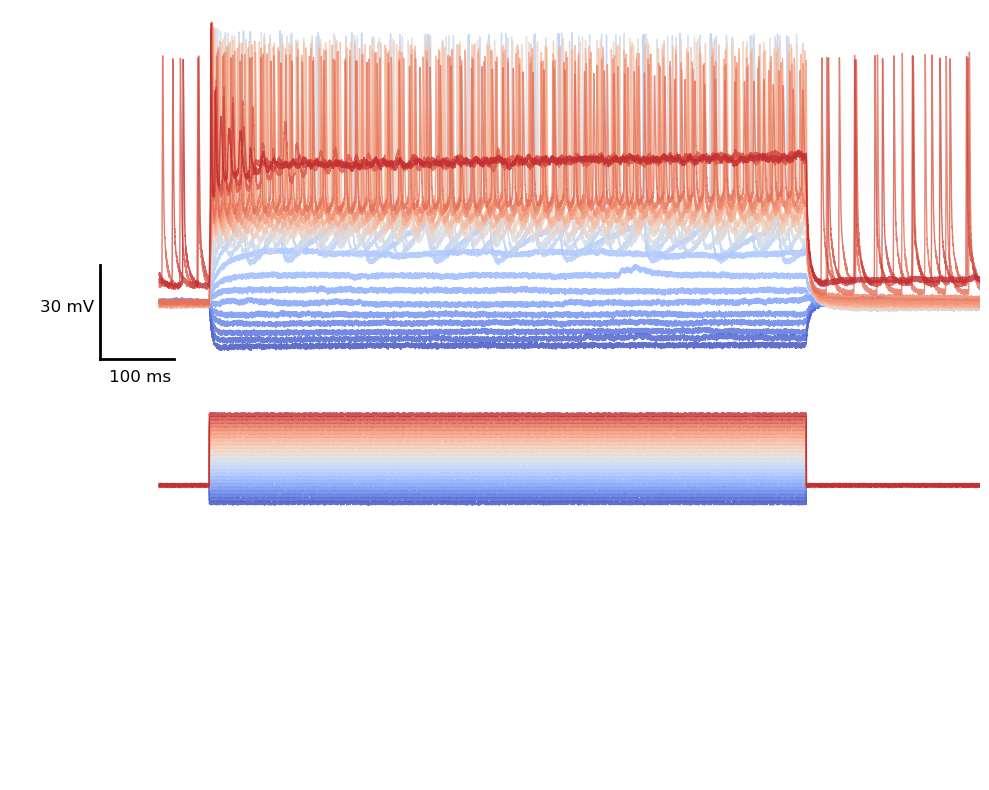

In [13]:
def plot_2D (cm):
    """ Standard 2D Clampfit-like plot of all traces."""
    
    fig, ax = plt.subplots(2,1, figsize = (10,8), dpi = 100)
    
    x_max = 0
    x_min = 0
    y_max = 0
    y_min = 0
    cmd_max = 0
    cmd_min = 0
    
    for sweep in sweep_list:
        #colors = cm
        colors = [cm(x/abf.sweepCount) for x in sweep_list]
        
        # Get X and Y from In0
        abf.setSweep (sweepNumber = sweep, channel = 0)
        x = abf.sweepX
        y = abf.sweepY
        ax[0].plot (x, y, linestyle = 'solid', lw = 1, color=colors[sweep], alpha = 0.8)

        # Get Command Y
        abf.setSweep (sweepNumber = sweep, channel = 1)
        cmd = abf.sweepY
        ax[1].plot (x, cmd, linestyle = 'solid', lw = 1, color=colors[sweep], alpha = 0.8)
       
        # Get max and min of x, y, and cmd
        x_max = max (x)
        x_min = min (x)
        y_max = max ([max(y), y_max])
        y_min = min ([min(y), y_min])
        cmd_max = max ([max(cmd),cmd_max])
        cmd_min = min([min(cmd),cmd_min])
        
    # Remove frame
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False) 
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False) 
    ax[1].spines['right'].set_visible(False)
    
    # Remove ticks and tick labeles
    ax[0].set_xticks ([])
    ax[0].set_yticks ([])
    ax[1].set_xticks ([])
    ax[1].set_yticks ([])
    
    # Set axis limits
    x_min = -0.2
    y_min = y_min + y_min * 0.15
    y_max = y_max + y_max * 0.15
    cmd_min = cmd_min + cmd_min * 10
    cmd_max = cmd_max + cmd_max * 0.15
    
    ax[0].set_xlim(x_min, x_max)
    ax[0].set_ylim(y_min, y_max)
    ax[1].set_xlim(x_min, x_max)
    ax[1].set_ylim(cmd_min, cmd_max)
    
    # Add scalebars
    x_range = x_max - x_min
    y_range = y_max - y_min
    cmd_range = cmd_max - cmd_min
    
    x_width = -0.08, -0.08 + (x_range/13)
    y_height = (y_min - y_min * 0.1), (y_min - y_min * 0.1) + y_range/4

    ax[0].plot (x_width, [(y_min - y_min * 0.1)] * 2, lw = 2, color = 'black')
    ax[0].plot ([-0.08] * 2, y_height, lw = 2, color = 'black')
    ax[0].annotate(str(round(y_range/4,-1)).replace('.0','') + ' mV' , xy = (-0.16, (y_min - y_min * 0.1) + y_range/8), fontsize = 12)
    ax[0].annotate(str(round(x_range/13 * 1000,0)).replace('.0','') + ' ms', xy = (-.1 + x_range/40,(y_min - y_min * 0.02)), fontsize = 12)
    
    plt.tight_layout()
    # save the figure
    plt.savefig (file_in.replace('.abf','_2d.jpg'), dpi=300, orientation='portrait')

    
    
#---- Run the plot_2d() Function ----#    
cm = plt.get_cmap("coolwarm")
plot_2D(cm)

## Color Map Reference

https://matplotlib.org/3.2.0/tutorials/colors/colormaps.html